### Setup
Import plotting dependencies, load the raw CSV for data-quality checks, and read the cleaned output for downstream visuals.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

project_root = (Path.cwd() / '..').resolve()
raw_path = project_root / 'dataset' / 'Manila_City_Only_List.csv'
clean_path = Path('Missing People - cleaned.csv')

df_raw = pd.read_csv(raw_path)

if not clean_path.exists():
    raise FileNotFoundError("Run 01_data_preprocessing.ipynb first to generate 'Missing People - cleaned.csv'.")

df_clean = pd.read_csv(clean_path)
df_clean['Date Reported Missing'] = pd.to_datetime(df_clean['Date Reported Missing'], errors='coerce')
df_clean['Date Last Seen'] = pd.to_datetime(df_clean['Date Last Seen'], errors='coerce')
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')
df_clean['Hour_Missing'] = pd.to_numeric(df_clean['Hour_Missing'], errors='coerce')
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')

df_clean.head()

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_92865/4006821296.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,Adult,Manila City,NaN,Malate,14.5714,120.9904,district,1.0,2020.0,12.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,Adult,Manila City,NaN,Sampaloc,14.6133,121.0003,district,1.0,2020.0,17.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaT,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,Adult,Manila City,NaN,Tondo,14.6186,120.9681,district,1.0,2020.0,19.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,Young Teen,Manila City,NaN,Binondo,14.6006,120.9754,district,1.0,2020.0,12.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,Teen,Manila City,NaN,Paco,14.5833,120.9961,district,1.0,2020.0,12.0


### Missing Value Overview
Counts nulls and literal `"na"` entries per column, then plots the worst offenders.

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_92865/1685900425.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r')


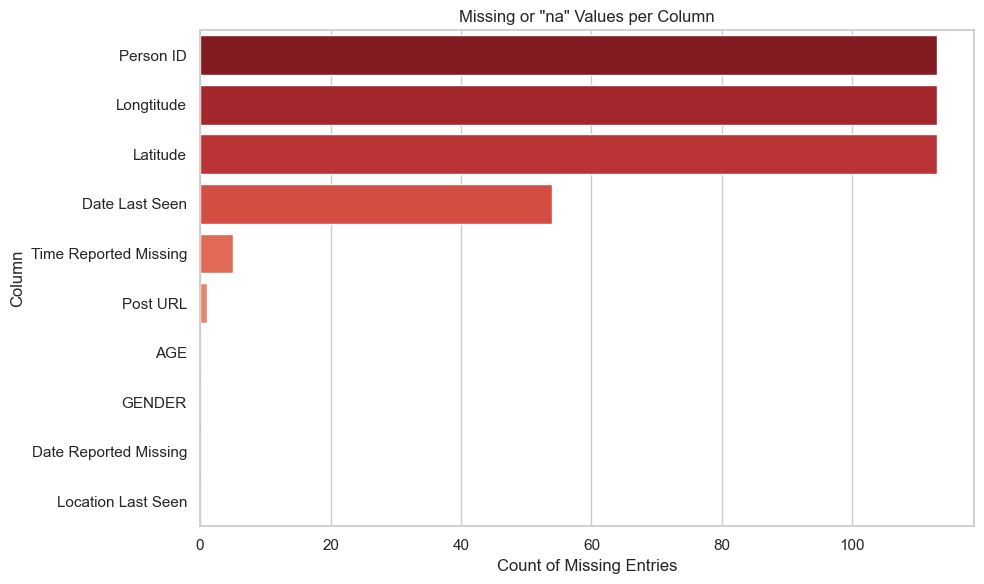

,Column,Missing Count
0,Person ID,113
7,Longtitude,113
8,Latitude,113
5,Date Last Seen,54
4,Time Reported Missing,5
9,Post URL,1
1,AGE,0
2,GENDER,0
3,Date Reported Missing,0
6,Location Last Seen,0


In [2]:
missing_counts = {}
for col in df_raw.columns:
    nan_count = df_raw[col].isnull().sum()
    if df_raw[col].dtype == 'object':
        na_str_count = df_raw[col].astype(str).str.strip().str.lower().eq('na').sum()
    else:
        na_str_count = 0
    missing_counts[col] = nan_count + na_str_count

missing_df = (
    pd.DataFrame(list(missing_counts.items()), columns=['Column', 'Missing Count'])
      .sort_values(by='Missing Count', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r')
plt.title('Missing or "na" Values per Column')
plt.xlabel('Count of Missing Entries')
plt.tight_layout()
plt.show()

missing_df

### Age Distribution
Visualizes the smart age bins introduced during preprocessing.

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_92865/2360786805.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')


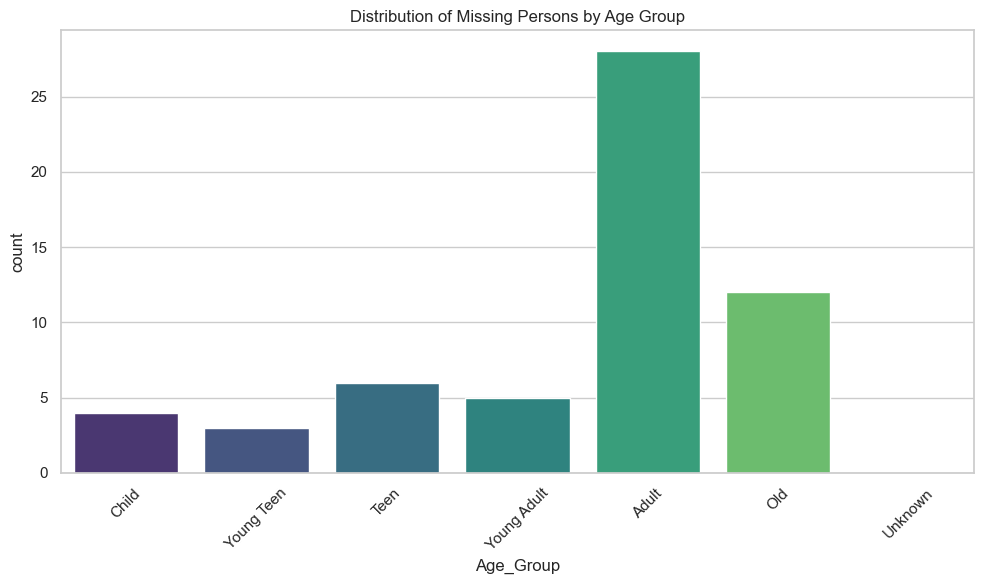

In [3]:
order = ['Child', 'Young Teen', 'Teen', 'Young Adult', 'Adult', 'Old', 'Unknown']
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')
plt.title('Distribution of Missing Persons by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Hourly Pattern
Highlights peak reporting times using the derived `Hour_Missing` feature.

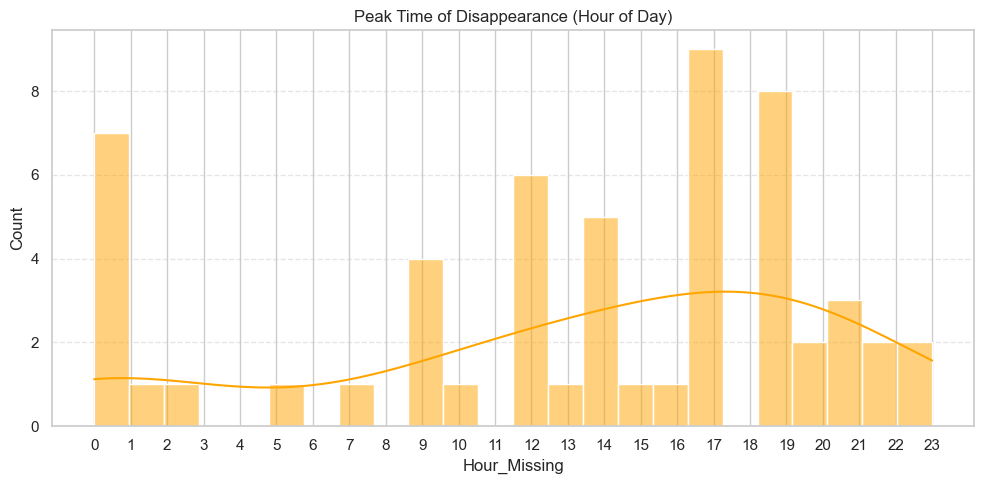

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='Hour_Missing', bins=24, kde=True, color='orange')
plt.title('Peak Time of Disappearance (Hour of Day)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Location Completeness
Checks how often `Location Last Seen` is populated after cleaning.

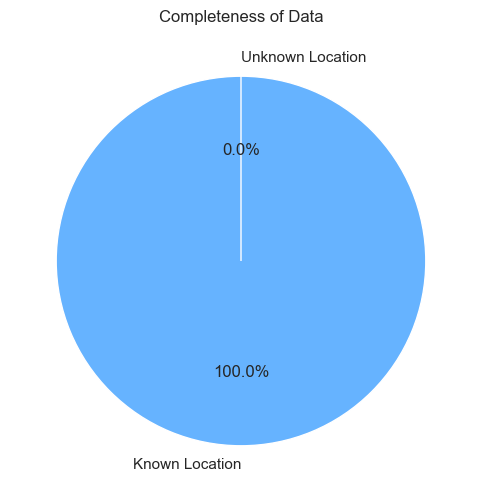

In [5]:
missing_loc_count = df_clean['Location Last Seen'].isnull().sum() + \
                    (df_clean['Location Last Seen'].astype(str).str.lower() == 'na').sum()
present_loc_count = len(df_clean) - missing_loc_count

plt.figure(figsize=(6, 6))
plt.pie([present_loc_count, missing_loc_count], labels=['Known Location', 'Unknown Location'],
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Completeness of Data')
plt.show()

### Seasonal Pattern
Polar chart to inspect month-by-month variation in reports.

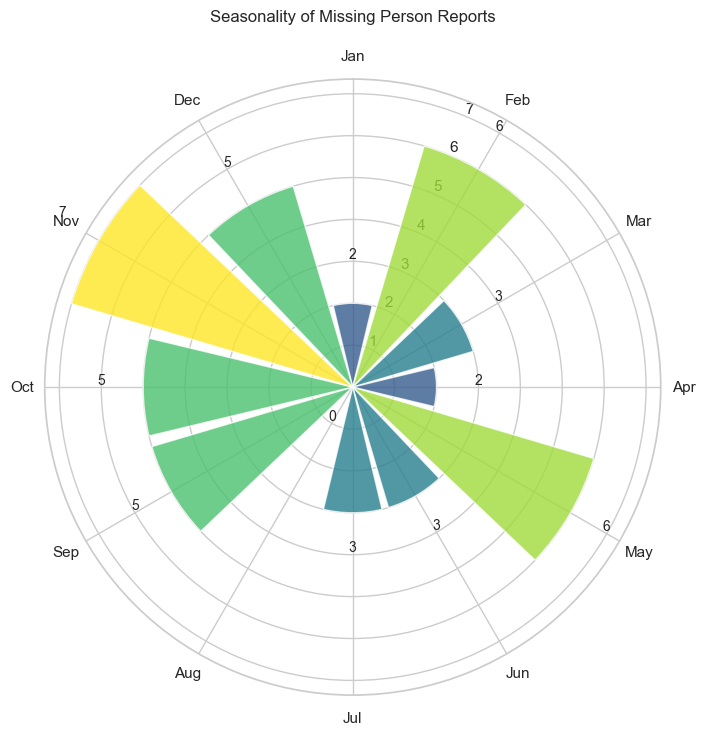

In [6]:
df_dates = df_clean.dropna(subset=['Date Reported Missing']).copy()
df_dates['Month'] = df_dates['Date Reported Missing'].dt.month
monthly_counts = df_dates['Month'].value_counts().sort_index()
for m in range(1, 13):
    if m not in monthly_counts:
        monthly_counts[m] = 0
monthly_counts = monthly_counts.sort_index()

theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
width = (2 * np.pi) / 12 * 0.9

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

bars = ax.bar(theta, monthly_counts.values, width=width, bottom=0.0, alpha=0.8,
              color=plt.cm.viridis(monthly_counts.values / max(monthly_counts.values)))

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(theta)
ax.set_xticklabels(month_labels)

for bar, angle, count in zip(bars, theta, monthly_counts.values):
    ax.text(angle, bar.get_height() + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Seasonality of Missing Person Reports', y=1.08)
plt.show()

### Timeline
Monthly counts across the entire observation window.

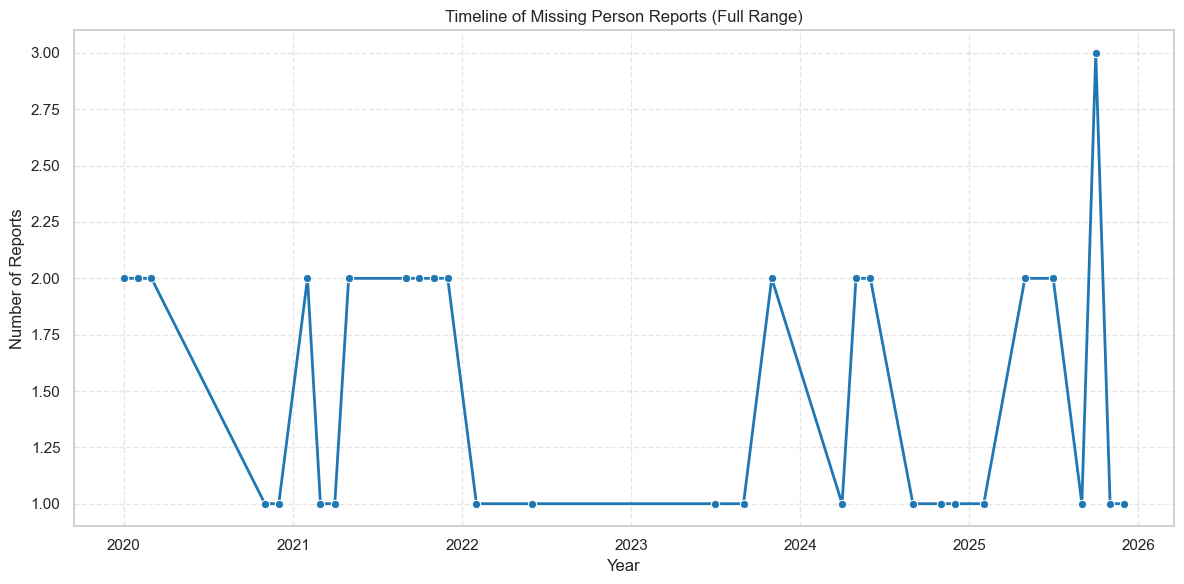

In [7]:
monthly_counts = df_clean.groupby(df_clean['Date Reported Missing'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o', color='#1f77b4', linewidth=2)
plt.title('Timeline of Missing Person Reports (Full Range)')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Metro Manila City Comparison
Shows annual case counts per Metro Manila city based on the cleaned location labels.

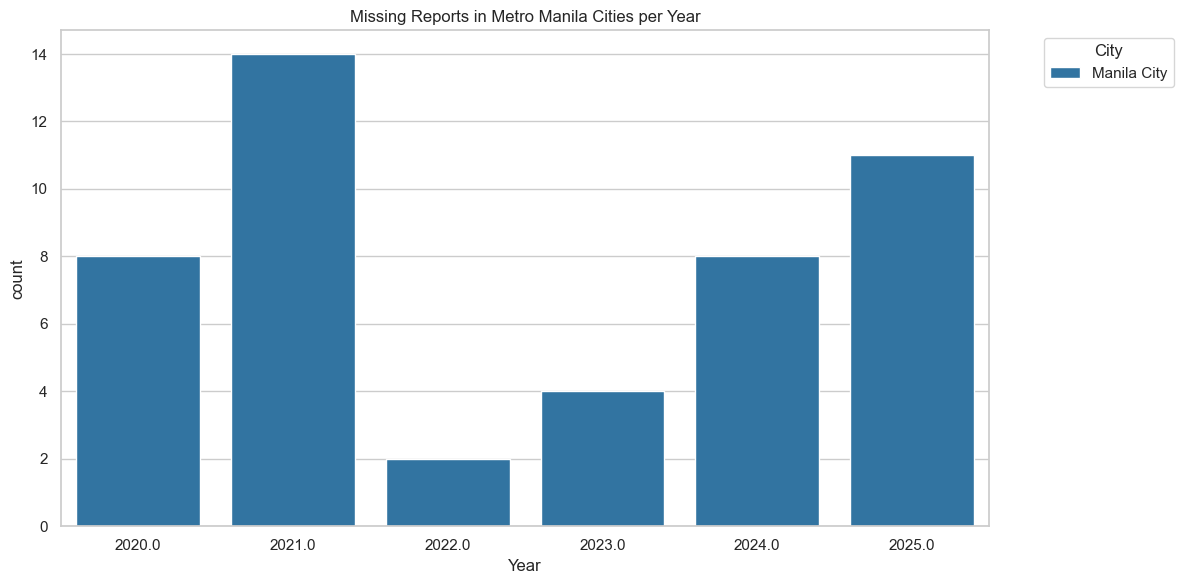

Total number of Metro Manila cases from 2020-2025: 47


In [8]:
df_mm = df_clean[df_clean['City_Cleaned'] != 'Other/Unknown'].dropna(subset=['Year']).copy()
plt.figure(figsize=(12, 6))
sns.countplot(data=df_mm, x='Year', hue='City_Cleaned', palette='tab20')
plt.title('Missing Reports in Metro Manila Cities per Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='City')
plt.tight_layout()
plt.show()

cases_2020_2025 = df_mm[(df_mm['Year'] >= 2020) & (df_mm['Year'] <= 2025)].shape[0]
print(f'Total number of Metro Manila cases from 2020-2025: {cases_2020_2025}')

### District Distribution
Breaks down the cleaned Manila cases by matched district to highlight hotspots after fuzzy matching.

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_92865/3993970300.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=display_df, y='District_Cleaned', x='Count', palette='mako')


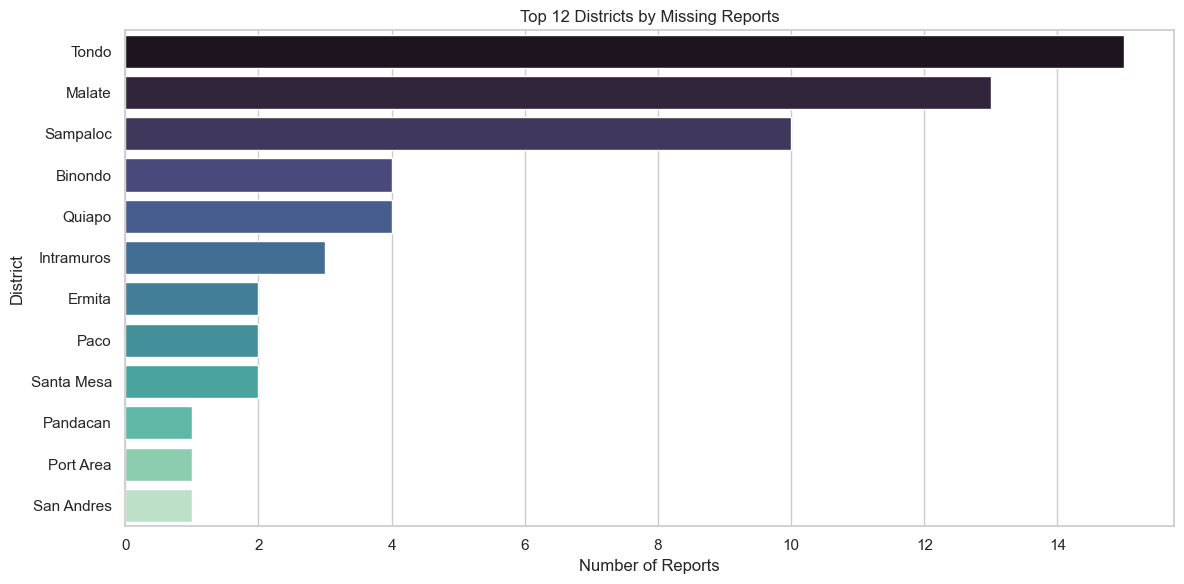

,District_Cleaned,Count
0,Tondo,15
1,Malate,13
2,Sampaloc,10
3,Binondo,4
4,Quiapo,4
5,Intramuros,3
6,Ermita,2
7,Paco,2
8,Santa Mesa,2
9,Pandacan,1


In [9]:
district_counts = (
    df_clean[df_clean['District_Cleaned'].notna()]
    .groupby('District_Cleaned')
    .size()
    .sort_values(ascending=False)
)

top_n = 20
display_df = district_counts.head(top_n).rename('Count').reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=display_df, y='District_Cleaned', x='Count', palette='mako')
plt.title(f'Top {min(top_n, len(display_df))} Districts by Missing Reports')
plt.xlabel('Number of Reports')
plt.ylabel('District')
plt.tight_layout()
plt.show()

if len(district_counts) > top_n:
    print(f"Remaining {len(district_counts) - top_n} districts grouped into 'Other'.")
display_df